# Using `redflag`

It's early days, but there are a few things you can do:

- Outlier detection
- Clipping detection
- Imbalance metrics (for labels and any other categorical variables)
- Distribution shape

In [1]:
import redflag as rf

rf.__version__

'0.1.8.dev12+gd3d89b1.d20220706'

## Load some data

In [2]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Well Name      3966 non-null   object 
 1   Depth          3966 non-null   float64
 2   Formation      3966 non-null   object 
 3   RelPos         3966 non-null   float64
 4   Marine         3966 non-null   int64  
 5   GR             3966 non-null   float64
 6   ILD            3966 non-null   float64
 7   DeltaPHI       3966 non-null   float64
 8   PHIND          3966 non-null   float64
 9   PE             3966 non-null   float64
 10  Facies         3966 non-null   float64
 11  LATITUDE       3966 non-null   float64
 12  LONGITUDE      3966 non-null   float64
 13  ILD_log10      3966 non-null   float64
 14  Lithology      3966 non-null   object 
 15  RHOB           3966 non-null   float64
 16  Mineralogy     3966 non-null   object 
 17  Siliciclastic  3966 non-null   bool   
dtypes: bool(

## Outliers

The `get_outliers()` function detects outliers, returning the indices of outlier points.

In [4]:
outliers = rf.get_outliers(df['PHIND'])
outliers

array([ 622,  759,  850, 1496, 2926, 2927, 3088, 3089, 3113])

In [5]:
df.loc[outliers, 'PHIND']

622     49.715
759     51.805
850     51.300
1496    50.850
2926    48.464
2927    52.369
3088    48.597
3089    49.787
3113    47.721
Name: PHIND, dtype: float64

<AxesSubplot:xlabel='PHIND', ylabel='Count'>

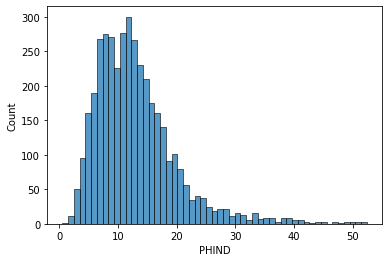

In [6]:
import seaborn as sns

sns.histplot(df['PHIND'])

A helper function can compute the number of expected outliers, given the dataset size and assuming a Gaussian distribution of samples.

In [7]:
rf.expected_outliers(df['PHIND'].size)

10.707391081429826

## Clipping

If a feature has been clipped, it will have multiple instances at its min and/or max value. There are legitimate reasons why this might happen, for example the feature may be naturally bounded (e.g. porosity is always greater than 0), or the feature may have been deliberately clipped as part of the data preparation process.

In [8]:
rf.is_clipped(df['GR'])

True

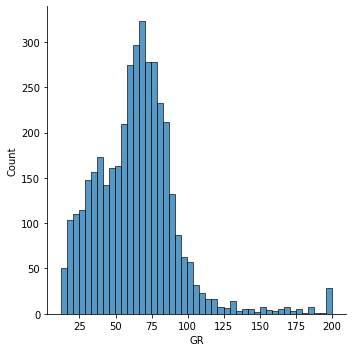

In [9]:
import seaborn as sns

sns.displot(df['GR'])

## Imbalance metrics

For binary targets, the metric is imbalace ratio (ratio between majority and minority class).

For multiclass targets, the metric is imbalance degree, a single-value measure that explains (a) how many minority classes there are and (b) how skewed the supports are.

In [10]:
rf.class_imbalance(df['Lithology'])

3.378593040847201

We can get the minority classes, which are those with fewer samples than expected. These are returned in order, smallest first:

In [11]:
rf.minority_classes(df['Lithology'])

array(['dolomite', 'sandstone', 'mudstone', 'wackestone'], dtype='<U10')

We can get the 'empirical distribution', which returns the observed frequencies `ζ` and the expectations `e`. 

In [12]:
ζ, e = rf.empirical_distribution(df['Lithology'])
ζ

array([0.39989914, 0.18582955, 0.15834594, 0.04790721, 0.13691377,
       0.07110439])

These are in the same order as `df['Lithology'].unique()` (note that this is different from the order of `np.unique()`, which is sorted).

In [13]:
df['Lithology'].unique()

array(['siltstone', 'limestone', 'wackestone', 'dolomite', 'mudstone',
       'sandstone'], dtype=object)

We can also inspect the distribution using Pandas; note that this display is sorted by count:

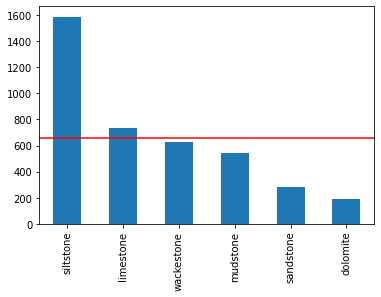

In [14]:
import matplotlib.pyplot as plt

df['Lithology'].value_counts().plot(kind='bar')

# Add a line at the expectation level, which is the same for all classes.
plt.axhline(e[0] * len(df), c='r')

## Distribution shape

Tries to guess the shape of the distribution from the following set from `scipy.stats`:

- `'norm'`
- `'cosine'`
- `'expon'`
- `'exponpow'`
- `'gamma'`
- `'gumbel_l'`
- `'gumbel_r'`
- `'powerlaw'`
- `'triang'`
- `'trapz'`
- `'uniform'`

The name is returned, along with the shape parameters (if any), location and scale.

In [15]:
rf.best_distribution(df['PHIND'])

Distribution(name='gumbel_r', shape=[], loc=10.040572536302586, scale=4.934329727517257)

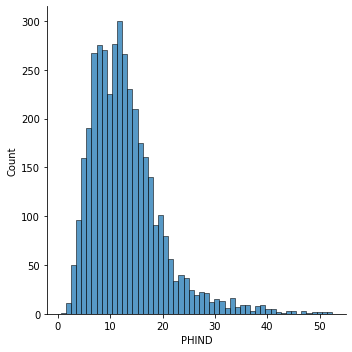

In [16]:
sns.displot(df['PHIND'])

## Identical distribution assumption

We'd often like to test the implicit assumption that our data are 'identically distributed' across various groups, with respect to both the labels and the features.

`redflag.wasserstein()` facilitates calculating the first Wasserstein distance (aka earth-mover's distance) between groups, e.g. between train and test datasets. It returns a score for each feature; scores greater than 1 can be interpreted as substantial differences in the distribution.

In [17]:
wells = df['Well Name']
features = ['GR', 'RHOB', 'ILD_log10', 'PE']

w = rf.wasserstein(df[features], groups=wells)
w

array([[0.25985545, 0.28404634, 0.49139232, 0.33701782],
       [0.22736457, 0.13473663, 0.33672956, 0.20969657],
       [0.41216725, 0.34568777, 0.39729747, 0.48092099],
       [0.0801856 , 0.10675027, 0.13740318, 0.10325295],
       [0.19913347, 0.21828753, 0.26995735, 0.33063277],
       [0.24612402, 0.23889923, 0.26699721, 0.2350674 ],
       [0.20666445, 0.44112543, 0.16229232, 0.63527036],
       [0.18187639, 0.34992043, 0.19400917, 0.74988182],
       [0.31761526, 0.27206283, 0.30255291, 0.24779581]])

You could plot this as a heatmap:

<AxesSubplot:>

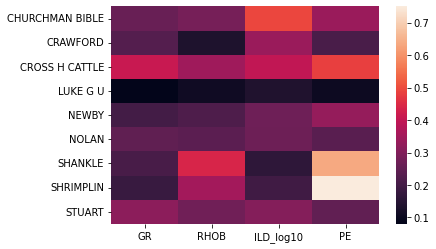

In [18]:
import numpy as np

sns.heatmap(w, yticklabels=np.unique(wells), xticklabels=features)

This shows us that the distributions of the PE log in well indices 6 and 7 are somewhat different and may be anomalous. It also suggests that the CROSS H CATTLE well is different from the others.

### Already split out group arrays

If you have groups that are already split out, e.g. train and test datasets:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_ = train_test_split(df[features], test_size=0.4, random_state=42)

# NOTE: We're doing a random split here for illustration purposes only.
# This is not a valid way to split the dataset, because rows are not indepedent.
X_val, X_test = train_test_split(X_, test_size=0.5, random_state=42)

In this case, you can pass them into the function as a list or tuple:

In [20]:
rf.wasserstein([X_train, X_val, X_test])

array([[0.03868682, 0.02536174, 0.04371856, 0.03420413],
       [0.04411461, 0.02558425, 0.03895774, 0.05666165],
       [0.04396947, 0.05005485, 0.05624867, 0.03983004]])

## Self-correlation

If a feature is correlated to lagged (shifted) versions of itself, then the dataset may be ordered by that feature, or the records may not be independent. If several features are correlated to themselves, then the data instances may not be independent.

In [21]:
rf.is_correlated(df['GR'])

True

This is order-dependent. That is, shuffling the data removes the correlation, but does not mean the records are independent.

In [22]:
import numpy as np

gr = df['GR'].to_numpy(copy=True)
np.random.shuffle(gr)
rf.is_correlated(gr)

False

## Feature importance

We'd like to know which features are the most important.

`redflag` trains a series of models on your data, assessing which features are most important. It then normalizes and averages the results. 

To serve as a 'control', let's add a random column that we know is not useful. We'd expect this column to come out with very low importance (i.e. close to zero).

In [23]:
df['Random'] = np.random.normal(size=len(df))

First, a **classification task**. Imagine we're trying to predict lithology from well logs. Which are the most important logs?

In [24]:
features = ['GR', 'ILD_log10', 'RHOB', 'PE', 'Random']

X = df[features]
y = df['Lithology']

rf.feature_importances(X, y)

array([0.21787802, 0.20553982, 0.15881248, 0.36783507, 0.04609278])

This tells us that the most important features are, in order: PE, ILD, CR, RHOB, with the random variable a distant last.

Now we'll look at a **regression task**. We'll try to predict RHOB from the other logs (including the random variable). The function guesses that this is a regression task:

In [25]:
features = ['GR', 'ILD_log10', 'PE', 'Random']

X = df[features]
y = df['RHOB']

rf.feature_importances(X, y)

array([0.09160851, 0.41854958, 0.46365293, 0.02573345])

The most predictive features are PE and ILD, with GR substantially less important. Again, the random variable is the least important feature.